In [1]:
import pandas as pd
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
from collections import Counter
import random
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.util import varsim
import plotly.graph_objects as go
import webbrowser
import bisect

In [2]:
carpeta = '../Datasets/Datos_buenos/'

dataframes = []
archivos = []

for archivo in os.listdir(carpeta):
    if archivo.endswith('.csv'):
        ruta_completa = os.path.join(carpeta, archivo)
        archivos.append(archivo)
        df = pd.read_csv(ruta_completa)
        df = df.drop(columns=['steps_ms'])
        df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S.%f')
        dataframes.append(df)
        
        
num_dfs = len(dataframes)
    
labels_all = ['señal','unlabel','desplazandose','bebiendo','activa','inactiva',
              'comiendo','pis','acostandose','tumbada','levantandose']



In [3]:
dir_results = '../Results/'
dir_figures = '../Results/Figures/'

Agrupamos las etiquetas en 'unlabel', 'desplazandose', 'inactiva', 'activa', 'comiendo' y 'tumbada'.

In [4]:
for i, df in enumerate(dataframes):
    etiquetas = df['label'].copy()

    # Reemplazos simples
    etiquetas.replace({
        'señal': 'unlabel',
        'bebiendo': 'comiendo',
        'pis': 'inactiva'
    }, inplace=True)

    # Reemplazo de 'acostandose' por la última etiqueta previa distinta
    for j in range(1, len(etiquetas)):
        if etiquetas.iloc[j] == 'acostandose':
            k = j - 1
            while k >= 0 and etiquetas.iloc[k] == 'acostandose':
                k -= 1
            if k >= 0:
                etiquetas.iloc[j] = etiquetas.iloc[k]

    # Reemplazo de 'levantandose' por la siguiente etiqueta distinta
    for j in reversed(range(len(etiquetas) - 1)):
        if etiquetas.iloc[j] == 'levantandose':
            k = j + 1
            while k < len(etiquetas) and etiquetas.iloc[k] == 'levantandose':
                k += 1
            if k < len(etiquetas):
                etiquetas.iloc[j] = etiquetas.iloc[k]

    # Asignamos de nuevo al DataFrame
    df['label'] = etiquetas
    dataframes[i] = df


Registrar cuál es la siguiente etiqueta distinta, y guardarlo en un diccionario.

In [5]:
etiquetas_objetivo = ['desplazandose', 'inactiva', 'activa', 'comiendo', 'tumbada']
siguientes_dict = {et: [] for et in etiquetas_objetivo}

for df in dataframes:
    etiquetas = df['label'].reset_index(drop=True)
    
    # Detectar bloques de etiquetas constantes
    cambios = (etiquetas != etiquetas.shift()).cumsum()
    grupos = df.groupby(cambios)
    
    etiquetas_grupo = [grupo['label'].iloc[0] for _, grupo in grupos]
    
    for i in range(len(etiquetas_grupo) - 1):
        actual = etiquetas_grupo[i]
        siguiente = etiquetas_grupo[i + 1]
        if actual in etiquetas_objetivo and siguiente in etiquetas_objetivo:
            siguientes_dict[actual].append(siguiente)

Grafica un histograma de frecuencias que muestra cuántas veces cada comportamiento fue la etiqueta siguiente después de una etiqueta dada.

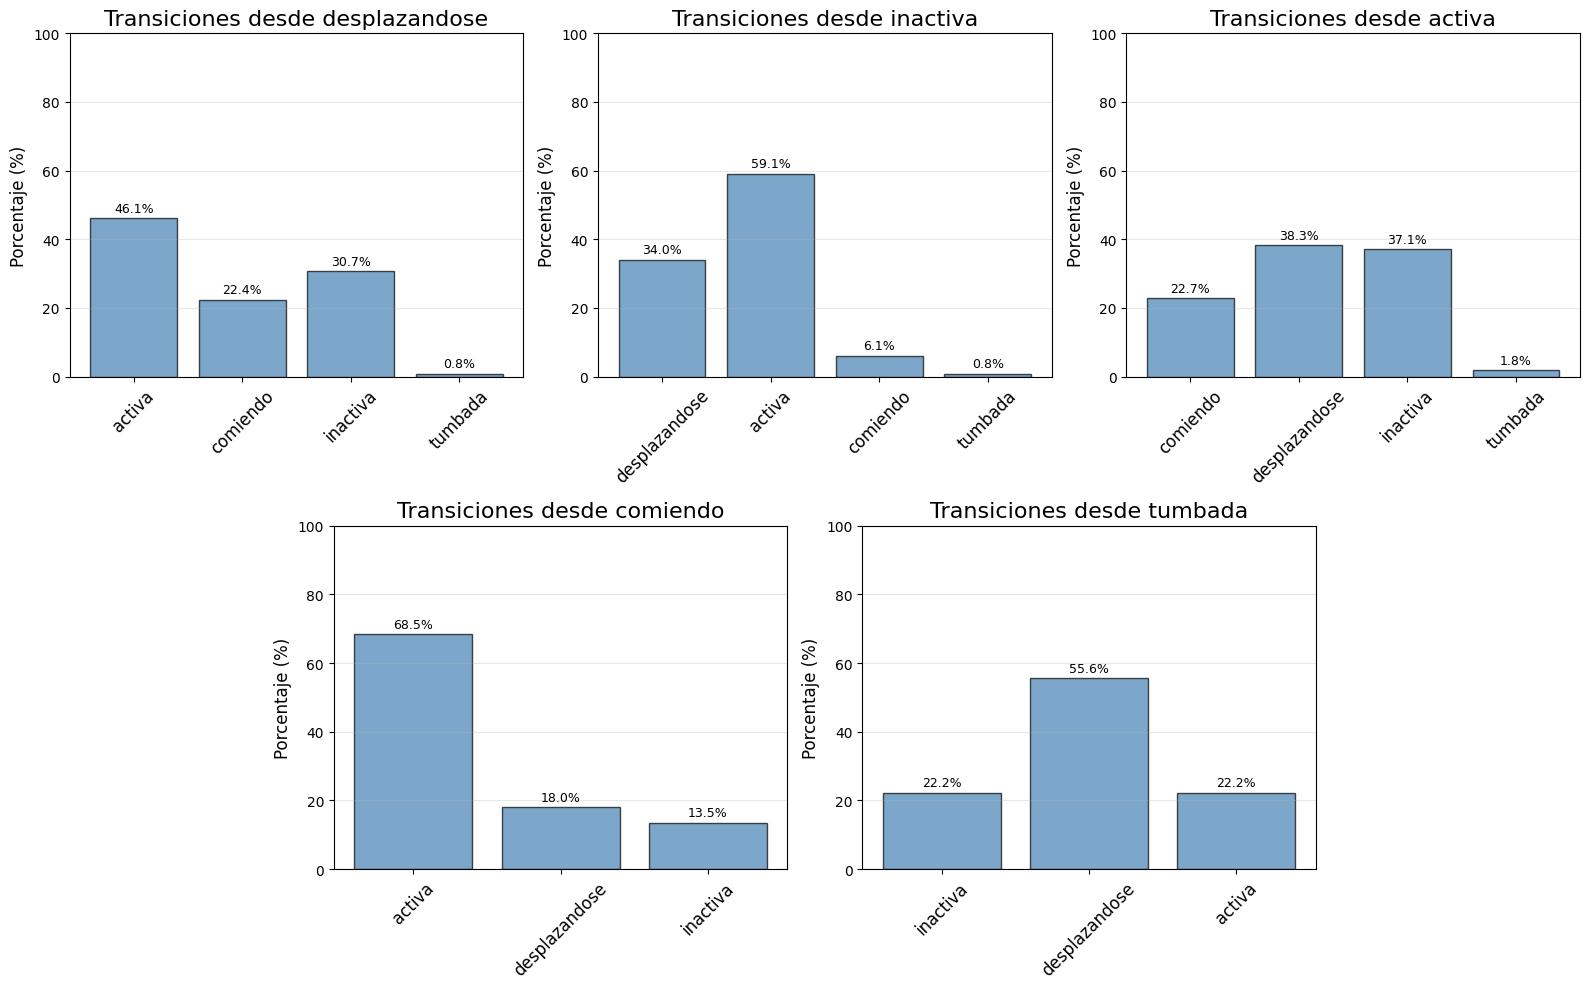

In [6]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 6, figure=fig)  # Dividimos cada fila en 6 columnas

axs = []

# Fila superior: ocupan columnas 0–1, 2–3, 4–5 (tres gráficas del mismo tamaño)
axs.append(fig.add_subplot(gs[0, 0:2]))
axs.append(fig.add_subplot(gs[0, 2:4]))
axs.append(fig.add_subplot(gs[0, 4:6]))

# Fila inferior: centradas
# Primera gráfica: mitad entre columna 1 y 2 (i.e., columnas 1–3)
axs.append(fig.add_subplot(gs[1, 1:3]))

# Segunda gráfica: mitad entre columna 3 y 4 (i.e., columnas 3–5)
axs.append(fig.add_subplot(gs[1, 3:5]))

# Dibujar las gráficas
for ax, (origen, destinos) in zip(axs, siguientes_dict.items()):
    conteo = Counter(destinos)
    total = sum(conteo.values())
    
    # Normalizar y convertir a porcentaje
    etiquetas = list(conteo.keys())
    porcentajes = [(v / total) * 100 for v in conteo.values()]

    # Crear el histograma
    bars = ax.bar(etiquetas, porcentajes, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_title(f'Transiciones desde {origen}', fontsize=16)
    ax.set_ylim(0, 100)
    ax.set_ylabel('Porcentaje (%)', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.grid(True, axis='y', alpha=0.3)

    # Añadir etiquetas de porcentaje encima de cada barra
    for bar, porcentaje in zip(bars, porcentajes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{porcentaje:.1f}%', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{dir_figures}FMPs_discretas.png", dpi=600)
plt.show()




Contruir y graficar, para cada etiqueta, su función de distribución acumulada (cdf) discreta sobre las etiquetas siguientes observadas. Guardar estas cdf en un diccionario que contenga 

cdf_dict[etiqueta] = {'etiquetas': ..., 'cdf': ...}.

In [7]:
cdf_dict = {}

# Recorremos los datos y generamos una figura por cada origen
for i, (origen, destinos) in enumerate(siguientes_dict.items()):
    conteo = Counter(destinos)

    # Filtrar etiquetas con frecuencia > 0
    etiquetas_filtradas = [et for et in etiquetas_objetivo if conteo[et] > 0]
    if not etiquetas_filtradas:
        continue

    # Crear vector de probabilidades en orden filtrado
    frecuencias = [conteo[et] for et in etiquetas_filtradas]
    total = sum(frecuencias)
    probabilidades = [f / total for f in frecuencias]
    cdf = [sum(probabilidades[:j+1]) for j in range(len(probabilidades))]

    # Guardar la cdf y etiquetas ordenadas en el diccionario
    cdf_dict[origen] = {
        'etiquetas': etiquetas_filtradas,
        'cdf': cdf
    }

    # Asignar posiciones numéricas a las etiquetas
    x = np.arange(len(etiquetas_filtradas))

    # Crear figura individual
    fig, ax = plt.subplots(figsize=(6, 5))

    # Graficar cdf discreta (tramos horizontales + puntos)
    for j in range(len(x)):
        x0 = x[j]
        x1 = x[j + 1] if j + 1 < len(x) else x[j] + 1
        y = cdf[j]

        if j == 0:
            ax.vlines(x0, 0, y, colors='gray', linestyles='dashed', linewidth=1)

        ax.hlines(y, x0, x1, colors='darkgreen', linewidth=2)
        ax.plot(x0, y, 'o', color='darkgreen')  # punto inicial
        if j + 1 < len(x):
            ax.plot(x1, y, 'o', markerfacecolor='white', markeredgecolor='darkgreen')  # punto vacío
            ax.vlines(x1, cdf[j], cdf[j+1], colors='darkgreen', linestyles='dashed', linewidth=1)

    # Etiquetas centradas
    centros = [(x[j] + x[j + 1]) / 2 for j in range(len(x) - 1)] + [x[-1] + 0.5]
    ax.set_xticks(centros)
    ax.set_xticklabels(etiquetas_filtradas, rotation=45, fontsize=12)

    ax.set_title(f'c.d.f: Transiciones desde {origen}', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)

    # Guardar figura
    plt.tight_layout()
    plt.savefig(f"{dir_figures}cdf_desde_{origen}.png", dpi=600)
    plt.close()



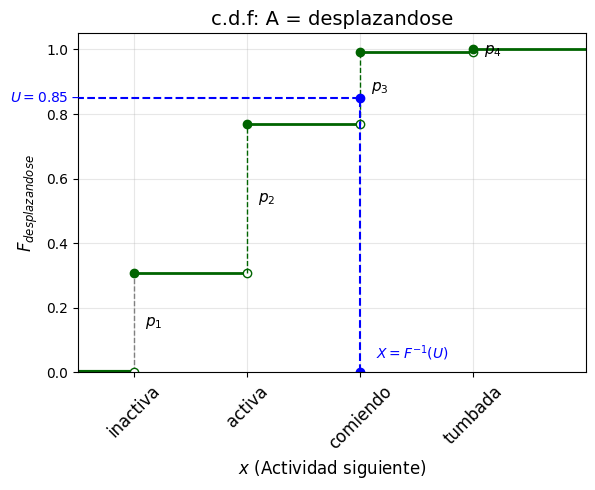

In [8]:
origen = 'desplazandose'
destinos = siguientes_dict[origen]

conteo = Counter(destinos)

# Filtrar etiquetas con frecuencia > 0
etiquetas_filtradas = [et for et in etiquetas_objetivo if conteo[et] > 0]

# Crear vector de probabilidades en orden filtrado
frecuencias = [conteo[et] for et in etiquetas_filtradas]
total = sum(frecuencias)
probabilidades = [f / total for f in frecuencias]
cdf = [sum(probabilidades[:j+1]) for j in range(len(probabilidades))]

# Asignar posiciones numéricas a las etiquetas
x = np.arange(len(etiquetas_filtradas))

# Crear figura individual
fig, ax = plt.subplots(figsize=(6, 5))

# Graficar cdf discreta (tramos horizontales + puntos)
for j in range(len(x)):
    x0 = x[j]
    x1 = x[j + 1] if j + 1 < len(x) else x[j] + 1
    y = cdf[j]

    if j == 0:
        ax.vlines(x0, 0, y, colors='gray', linestyles='dashed', linewidth=1)
        ax.text(x0 + 0.1, y / 2, r'$p_1$', color='black', fontsize=11, va='center')

    ax.hlines(y, x0, x1, colors='darkgreen', linewidth=2)
    ax.plot(x0, y, 'o', color='darkgreen')  # punto inicial
    if j + 1 < len(x):
        ax.plot(x1, y, 'o', markerfacecolor='white', markeredgecolor='darkgreen')  # punto vacío
        ax.vlines(x1, cdf[j], cdf[j+1], colors='darkgreen', linestyles='dashed', linewidth=1)
        # Etiqueta p_i junto a la línea de discontinuidad
        ax.text(x1 + 0.1, (cdf[j] + cdf[j + 1]) / 2, rf'$p_{{{j+2}}}$', color='black', fontsize=11, va='center')

ax.hlines(0, -1, 0, colors='darkgreen', linewidth=3)
ax.plot(0, 0, 'o', markerfacecolor='white', markeredgecolor='darkgreen')  # punto vacío


# Etiquetas centradas
centros = [x[j] for j in range(len(x) - 1)] + [x[-1]]
ax.set_xticks(centros)
ax.set_xticklabels(etiquetas_filtradas, rotation=45, fontsize=12)

ax.set_xlabel(r'$x$ (Actividad siguiente)', fontsize=12)
ax.set_ylabel(rf'$F_{{{origen}}}$', fontsize=12)

ax.set_title(f'c.d.f: A = {origen}', fontsize=14)
ax.set_ylim(0, 1.05)
ax.set_xlim(-0.5, len(x))
ax.grid(True, alpha=0.3)

# Línea horizontal discontinua azul
ax.hlines(0.85, -1, 2, colors='blue', linestyles='dashed', linewidth=1.5)
ax.vlines(2, 0, 0.85, colors='blue', linestyles='dashed', linewidth=1.5)
ax.plot(2, 0.85, 'o', color='blue')
ax.plot(2, 0, 'o', color='blue')

ax.text(-1.1, 0.85, r'$U = 0.85 -$', color='blue', fontsize=10, va='center')
ax.text(2.14, 0.06, r'$X = F^{-1}(U)$', color='blue', fontsize=10, va='center')

# Guardar figura
plt.tight_layout()
plt.savefig(f"{dir_figures}cdf_modif_desde_{origen}.png", dpi=600)
plt.show()


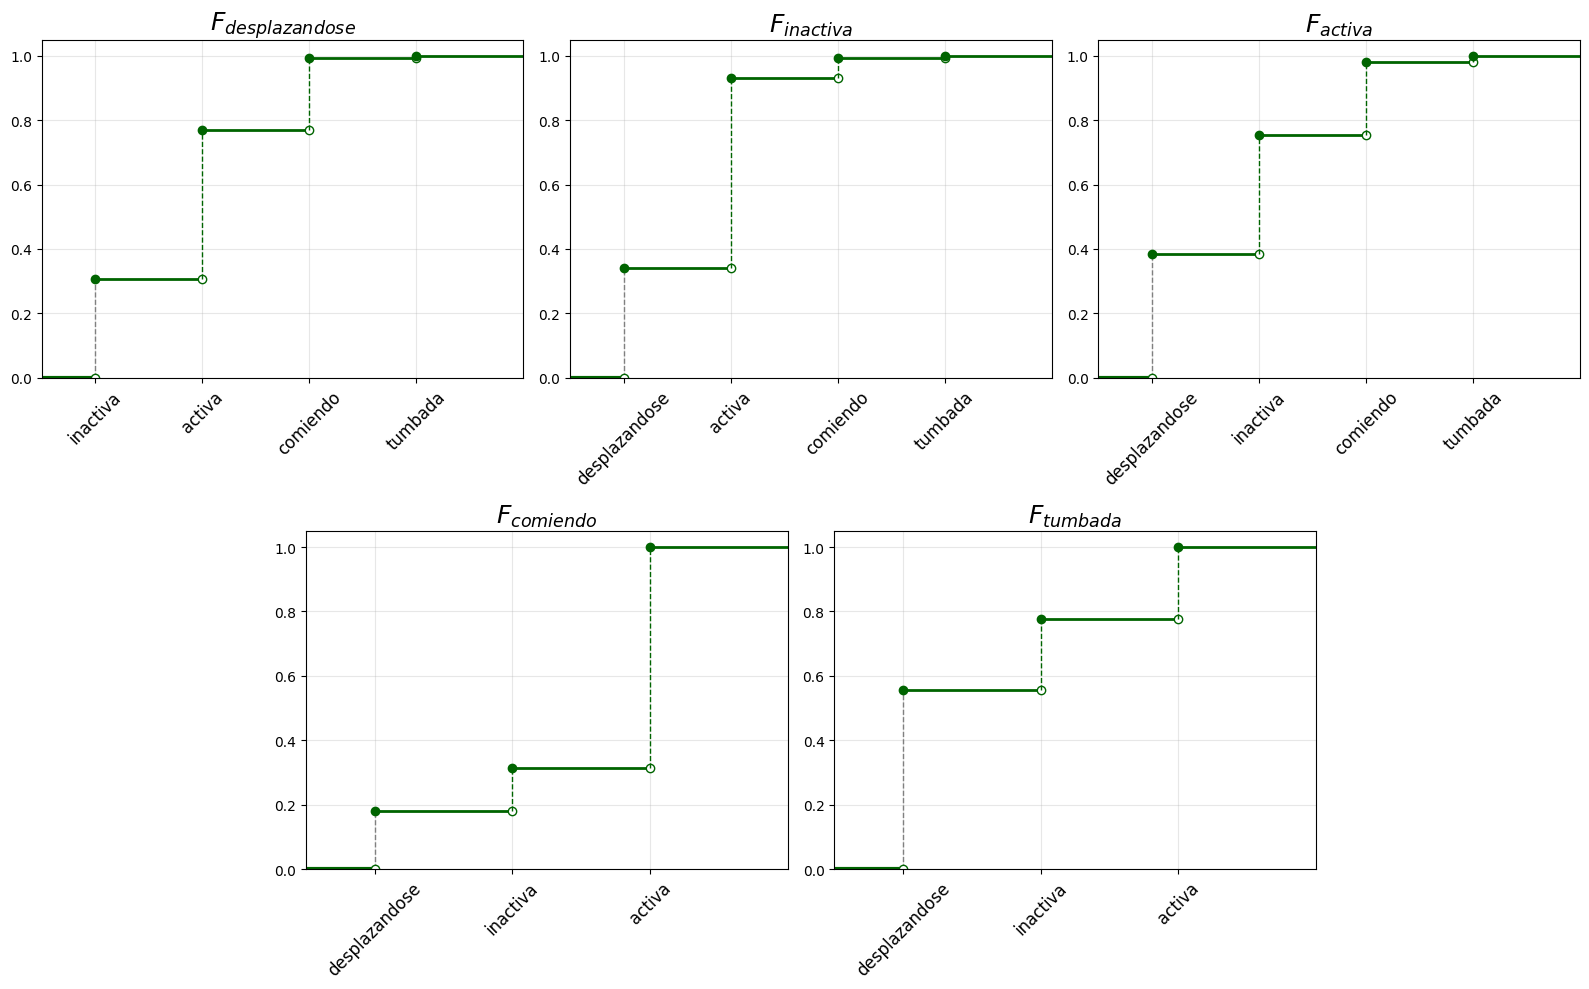

In [9]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 6, figure=fig)

axs = []

# Distribución 3 arriba
axs.append(fig.add_subplot(gs[0, 0:2]))
axs.append(fig.add_subplot(gs[0, 2:4]))
axs.append(fig.add_subplot(gs[0, 4:6]))

# Distribución 2 centradas abajo
axs.append(fig.add_subplot(gs[1, 1:3]))
axs.append(fig.add_subplot(gs[1, 3:5]))

# Recorrer datos y asignar cada uno a un subplot
for ax, (origen, destinos) in zip(axs, siguientes_dict.items()):
    conteo = Counter(destinos)

    # Filtrar etiquetas con frecuencia > 0
    etiquetas_filtradas = [et for et in etiquetas_objetivo if conteo[et] > 0]
    if not etiquetas_filtradas:
        continue

    # Crear vector de probabilidades en orden filtrado
    frecuencias = [conteo[et] for et in etiquetas_filtradas]
    total = sum(frecuencias)
    probabilidades = [f / total for f in frecuencias]
    cdf = [sum(probabilidades[:i+1]) for i in range(len(probabilidades))]

    # Asignar posiciones numéricas a las etiquetas
    x = np.arange(len(etiquetas_filtradas))

    # Graficar cdf discreta (tramos horizontales + puntos)
    for i in range(len(x)):
        x0 = x[i]
        x1 = x[i + 1] if i + 1 < len(x) else x[i] + 1
        y = cdf[i]

        if i == 0:
            ax.vlines(x0, 0, y, colors='gray', linestyles='dashed', linewidth=1)

        # Tramo horizontal
        ax.hlines(y, x0, x1, colors='darkgreen', linewidth=2)

        # Puntos inicial y final
        ax.plot(x0, y, 'o', color='darkgreen')  # punto inicial
        if i + 1 < len(x):
            ax.plot(x1, y, 'o', markerfacecolor='white', markeredgecolor='darkgreen')  # punto vacío final

            # Línea vertical discontinua al final del tramo
            ax.vlines(x1, cdf[i], cdf[i+1], colors='darkgreen', linestyles='dashed', linewidth=1)

    ax.hlines(0, -1, 0, colors='darkgreen', linewidth=3)
    ax.plot(0, 0, 'o', markerfacecolor='white', markeredgecolor='darkgreen')  # punto vacío
    
    # Etiquetas centradas
    centros = [x[i] for i in range(len(x) - 1)] + [x[-1]]
    ax.set_xticks(centros)
    ax.set_xticklabels(etiquetas_filtradas, rotation=45, fontsize=12)

    ax.set_title(rf'$F_{{{origen}}}$', fontsize=18)
    #ax.set_xlabel('Etiqueta siguiente')
    #ax.set_ylabel('Probabilidad acumulada')
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-0.5, len(x))
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{dir_figures}cdfs_discretas.png", dpi=600)
plt.show()

Calcular cuánto tiempo permanece un animal en cada comportamiento antes de cambiar al siguiente, y guardarlo en un diccionario.

In [10]:
etiquetas_objetivo = ['desplazandose', 'inactiva', 'activa', 'comiendo', 'tumbada']
duraciones_dict = {et: [] for et in etiquetas_objetivo}

for df in dataframes:
    etiquetas = df['label'].reset_index(drop=True)
    tiempos = df['time_stamp'].reset_index(drop=True)
    
    # Detectar cambios de etiqueta
    cambios = (etiquetas != etiquetas.shift()).cumsum()
    grupos = df.groupby(cambios)
    
    for _, grupo in grupos:
        etiqueta = grupo['label'].iloc[0]
        if etiqueta in etiquetas_objetivo:
            t0 = grupo['time_stamp'].iloc[0]
            t1 = grupo['time_stamp'].iloc[-1]
            duracion = (t1 - t0).total_seconds()
            duraciones_dict[etiqueta].append(duracion)

# Eliminamos aquellos valores negativos o 0's, ya que no tienen sentido
for etiqueta in duraciones_dict:
    duraciones_dict[etiqueta] = [d for d in duraciones_dict[etiqueta] if d > 0]

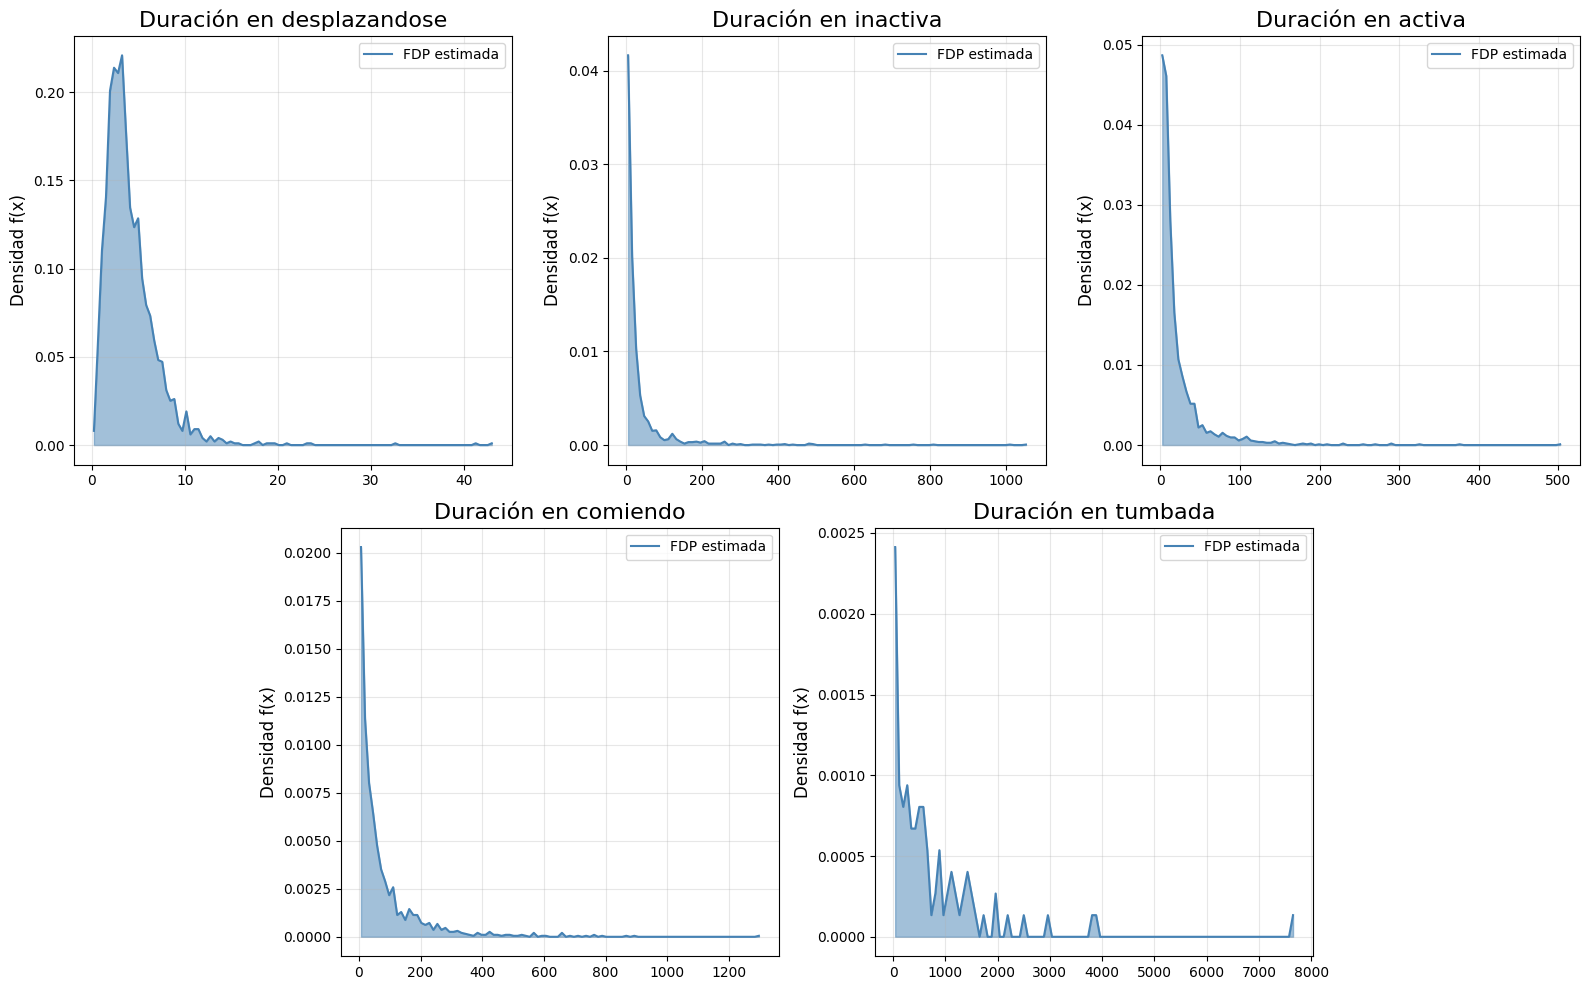

In [11]:
# Crear figura y cuadrícula
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 6, figure=fig)

axs = []

# Fila superior
axs.append(fig.add_subplot(gs[0, 0:2]))
axs.append(fig.add_subplot(gs[0, 2:4]))
axs.append(fig.add_subplot(gs[0, 4:6]))

# Fila inferior (centradas)
axs.append(fig.add_subplot(gs[1, 1:3]))
axs.append(fig.add_subplot(gs[1, 3:5]))

# Dibujar histogramas de densidad manualmente
for ax, (etiqueta, data) in zip(axs, duraciones_dict.items()):
    data = pd.Series(data).dropna()
    n = len(data)

    # Bins
    bins = np.linspace(0, data.max(), 100 + 1)  # 100 bins
    counts, _ = np.histogram(data, bins=bins)

    # Ancho del bin
    h = bins[1] - bins[0]

    # Densidad: f_i = N_i / (n * h)
    densities = counts / (n * h)

    # Centros de los bins
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Graficar
    ax.plot(bin_centers, densities, label='FDP estimada', alpha=1, color='steelblue')
    ax.fill_between(bin_centers, densities, alpha=0.5, color='steelblue')

    ax.set_title(f'Duración en {etiqueta}', fontsize=16)
    ax.set_ylabel(r'Densidad f(x)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Ajustar diseño y guardar
plt.tight_layout()
plt.savefig(f"{dir_figures}FDPs_continuas.png", dpi=600)
plt.show()

Ajustar una distribución exponencial Exp(\lambda) a los tiempos de permanencia en cada comportamiento animal, visualizar el ajuste con un histograma y guardar los parámetros del modelo para usarlos luego en simulaciones Monte Carlo. Guardar elos lambda ajustados a cada etiqueta en el diccionario:

parametros_exp[etiqueta] = (loc_exp, scale_exp),
donde scale_exp = 1/lambda y loc_exp es el parametro de desplazamiento. En este caso:

X = loc + scale (- ln U) seria la formula de generación de variables con esta distribución.

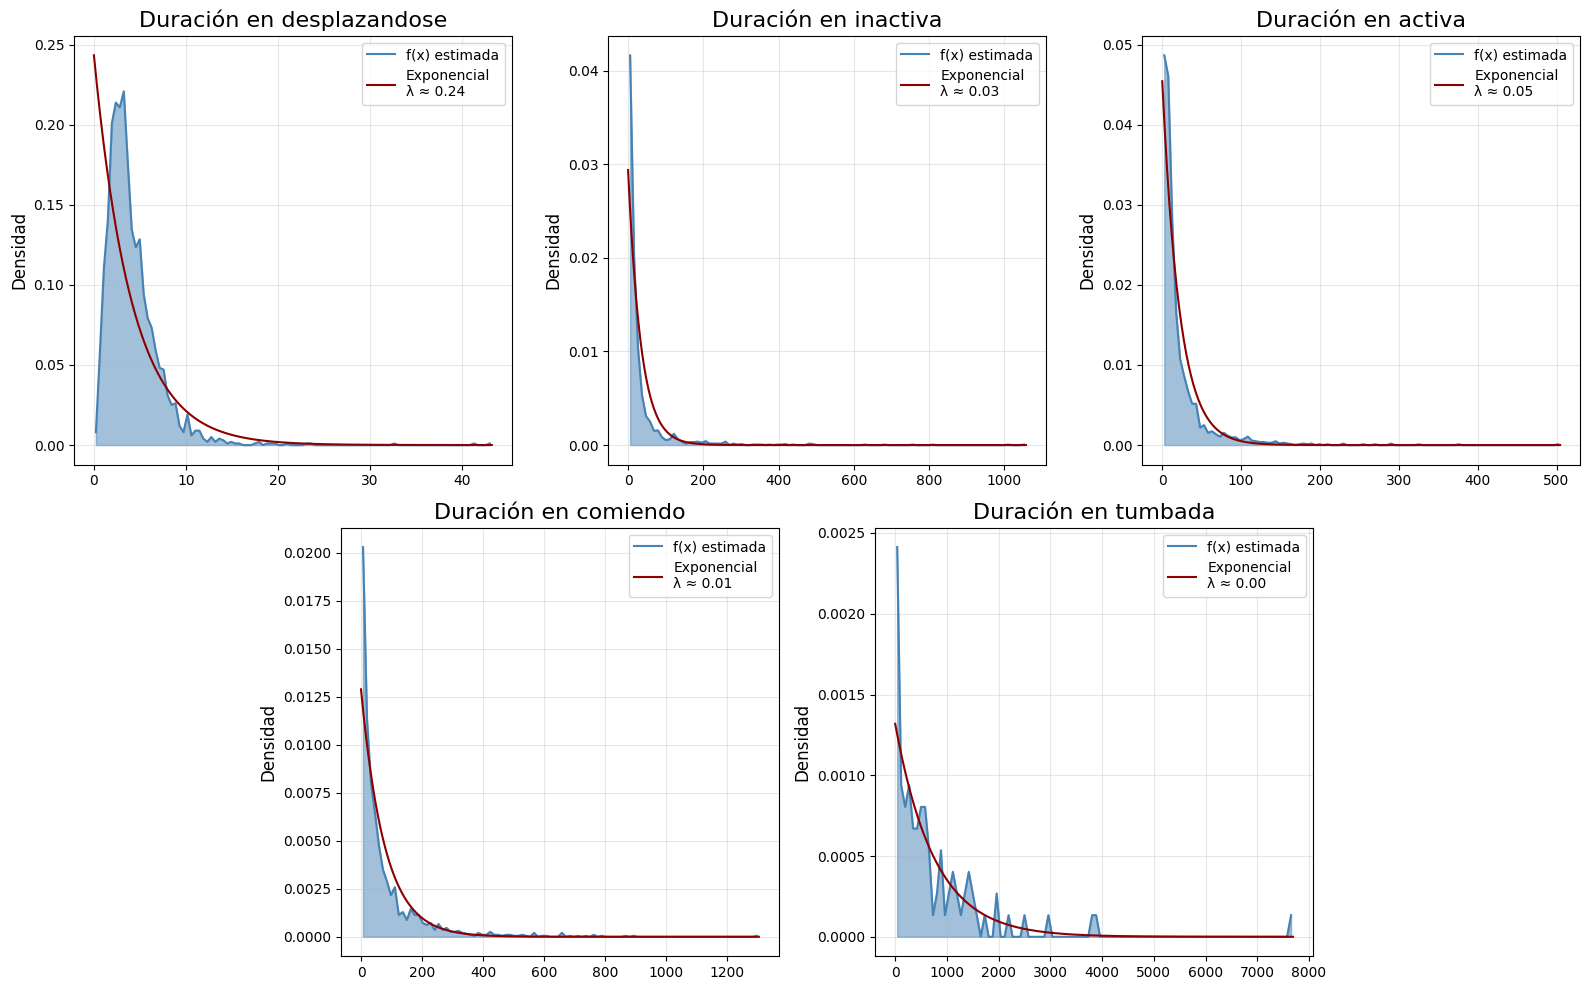

In [12]:
parametros_exp = {}

# Crear figura y cuadrícula
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 6, figure=fig)

axs = []

# Fila superior
axs.append(fig.add_subplot(gs[0, 0:2]))
axs.append(fig.add_subplot(gs[0, 2:4]))
axs.append(fig.add_subplot(gs[0, 4:6]))

# Fila inferior (centradas)
axs.append(fig.add_subplot(gs[1, 1:3]))
axs.append(fig.add_subplot(gs[1, 3:5]))

# Dibujar histogramas de densidad manualmente
for ax, (etiqueta, data) in zip(axs, duraciones_dict.items()):
    data = pd.Series(data).dropna()
    n = len(data)

    # Bins
    bins = np.linspace(0, data.max(), 100 + 1)  # 100 bins
    counts, _ = np.histogram(data, bins=bins)

    # Ancho del bin
    h = bins[1] - bins[0]

    # Densidad: f_i = N_i / (n * h)
    densities = counts / (n * h)

    # Centros de los bins
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Ajuste exponencial
    loc_exp, scale_exp = expon.fit(data, floc=0)
    x_vals = np.linspace(0, data.max(), 500)
    pdf_exp = expon.pdf(x_vals, loc=loc_exp, scale=scale_exp)

    # Guardar parámetros para simulación futura
    parametros_exp[etiqueta] = (loc_exp, scale_exp)

    # Graficar
    ax.plot(bin_centers, densities, label=r'f(x) estimada', alpha=1, color='steelblue')
    ax.fill_between(bin_centers, densities, alpha=0.5, color='steelblue')
    ax.plot(x_vals, pdf_exp, label=f'Exponencial\nλ ≈ {1/scale_exp:.2f}', color='darkred')

    ax.set_title(f'Duración en {etiqueta}', fontsize=16)
    ax.set_ylabel('Densidad', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Ajustar diseño y guardar
plt.tight_layout()
plt.savefig(f"{dir_figures}FDPs_continuas_ajustada.png", dpi=600)
plt.show()

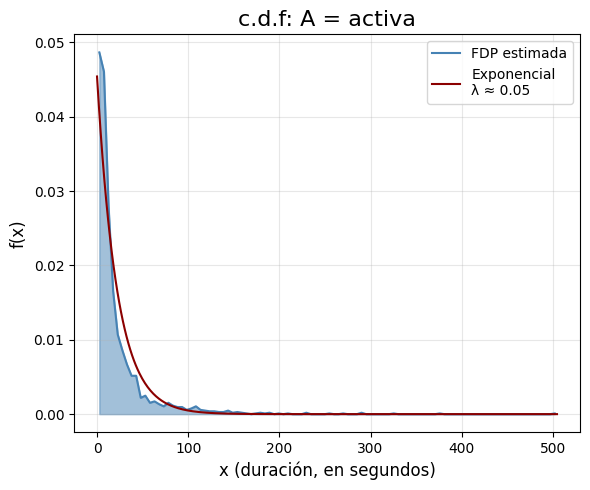

In [13]:
etiqueta = 'activa'
data = duraciones_dict[etiqueta]

data = pd.Series(data).dropna()
n = len(data)

# Bins
bins = np.linspace(0, data.max(), 100 + 1)  # 100 bins
counts, _ = np.histogram(data, bins=bins)

# Ancho del bin
h = bins[1] - bins[0]

# Densidad: f_i = N_i / (n * h)
densities = counts / (n * h)

# Centros de los bins
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Ajuste exponencial
loc_exp, scale_exp = expon.fit(data, floc=0)
x_vals = np.linspace(0, data.max(), 500)
pdf_exp = expon.pdf(x_vals, loc=loc_exp, scale=scale_exp)

fig, ax = plt.subplots(figsize=(6, 5))
# Graficar
ax.plot(bin_centers, densities, label='FDP estimada', alpha=1, color='steelblue')
ax.fill_between(bin_centers, densities, alpha=0.5, color='steelblue')
ax.plot(x_vals, pdf_exp, label=f'Exponencial\nλ ≈ {1/scale_exp:.2f}', color='darkred')

ax.set_title(f'c.d.f: A = {etiqueta}', fontsize=16)
ax.set_ylabel(r'f(x)', fontsize=12)
ax.set_xlabel(r'x (duración, en segundos)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()

# Ajustar diseño y guardar
plt.tight_layout()
plt.savefig(f"{dir_figures}FDPs_activa_continuas_ajustada.png", dpi=600)
plt.show()

Construir un modelo VAR (Vector Autoregresivo) para cada etiqueta de comportamiento animal, utilizando las señales de aceleración (acc_x, acc_y, acc_z), para simular trayectorias de movimiento correspondientes a cada comportamiento (como activa, tumbada, etc.).

In [14]:
# Almacenar todos los fragmentos por etiqueta
datos_por_etiqueta = {et: [] for et in etiquetas_objetivo}

# Recolectar los fragmentos
for df in dataframes:
    df = df[['label', 'acc_x', 'acc_y', 'acc_z']].copy()
    df = df.dropna()

    # Detectar bloques de etiqueta constante
    cambios = (df['label'] != df['label'].shift()).cumsum()
    grupos = df.groupby(cambios)

    for _, grupo in grupos:
        etiqueta = grupo['label'].iloc[0]
        if etiqueta in etiquetas_objetivo and len(grupo) > 10:
            datos_por_etiqueta[etiqueta].append(grupo[['acc_x', 'acc_y', 'acc_z']].reset_index(drop=True))


Ajustar modelo VAR usando p=100 (10 segundos) y guardar en el diccionario:

modelos_VAR[etiqueta] = modelo ajustado para la actividad etiqueta

In [15]:
# Ajustar modelos VAR por etiqueta
orden_p = 100  # Orden del modelo VAR (puedes ajustarlo u optimizarlo)
modelos_VAR = {}

for etiqueta in etiquetas_objetivo:
    print(f"Ajustando modelo VAR para: {etiqueta}")
    datos = pd.concat(datos_por_etiqueta[etiqueta], ignore_index=True)

    modelo = VAR(datos)
    resultado = modelo.fit(maxlags=orden_p)

    modelos_VAR[etiqueta] = resultado

Ajustando modelo VAR para: desplazandose
Ajustando modelo VAR para: inactiva
Ajustando modelo VAR para: activa
Ajustando modelo VAR para: comiendo
Ajustando modelo VAR para: tumbada


Construir una simulación completa de 2 horas de comportamiento animal (en este caso de una cabra), combinando tres niveles de simulación:

1. Simulación Monte Carlo discreta.
Para muestrear la etiqueta siguiente usando las cdf empíricas de transición (cdf_dict).

2. Simulación Monte Carlo continua.
Para muestrear la duración (en segundos) de permanencia en la etiqueta actual, usando la distribución exponencial ajustada (parametros_exp).

3. Simulación de señales VAR.
Para generar valores realistas de aceleración (acc_x, acc_y, acc_z) durante el tiempo de permanencia (modelos_VAR).

In [16]:
def simular_secuencia_actividades(actividad_inicial, tiempo_total, frecuencia=10, reduc_sigma = 1, semilla=0):
    """
    Simula una secuencia de actividades con datos de acelerómetro hasta tiempo_total (en segundos).
    
    Parámetros:
    - actividad_inicial: str, etiqueta de inicio.
    - tiempo_total: float, tiempo total en segundos.
    - frecuencia: int, frecuencia de muestreo en Hz (default 10 Hz = cada 0.1 s).
    - reduc_sigma: componente de reducción del error.
    - semilla: semilla para reproducir resultados.

    Retorna:
    - df_simulado: DataFrame con columnas ['acc_x', 'acc_y', 'acc_z', 'label', 'tiempo']
    """
    np.random.seed(semilla)
    random.seed(semilla)
    
    t = 0.0
    actividad_actual = actividad_inicial
    dt = 1.0 / frecuencia  # intervalo de muestreo
    lista_segmentos = []

    while t < tiempo_total:
        # 1. Simular duración
        loc, scale = parametros_exp[actividad_actual]
        duracion = loc - scale * np.log(np.random.uniform())  # duración en segundos
        duracion = min(duracion, tiempo_total - t)  # no exceder tiempo total
        num_obs = int(np.ceil(duracion / dt))

        # 2. Simular aceleraciones
        modelo = modelos_VAR[actividad_actual]
        p = modelo.k_ar
        datos_iniciales = modelo.endog[-p:]  # tomar las últimas observaciones del modelo

        if num_obs<p:
            num_obs=p
            duracion = p * dt

        #simulacion = modelo.simulate_var(initial_values=datos_iniciales, steps=num_obs, seed=semilla)
        simulacion = varsim(
            coefs=modelo.coefs,
            intercept=modelo.intercept,
            sig_u=modelo.sigma_u * reduc_sigma,
            initial_values=modelo.endog[-modelo.k_ar:],
            steps=num_obs,
            seed=int(semilla + t)
        )

        df_segmento = pd.DataFrame(simulacion, columns=['acc_x', 'acc_y', 'acc_z'])
        df_segmento['label'] = actividad_actual
        df_segmento['tiempo'] = np.round(np.arange(t, t + num_obs * dt, dt)[:num_obs], 3)

        lista_segmentos.append(df_segmento)
        t += num_obs * dt

        # 3. Transición a la siguiente actividad (si queda tiempo)
        if t >= tiempo_total:
            break
        cdf_info = cdf_dict[actividad_actual]
        etiquetas = cdf_info['etiquetas']
        cdf = cdf_info['cdf']
        u = random.random()
        idx = bisect.bisect_left(cdf, u)
        actividad_actual = etiquetas[idx]

    # Concatenar segmentos
    df_simulado = pd.concat(lista_segmentos, ignore_index=True)

    # Crear columna time_stamp a partir de tiempo en segundos
    inicio = pd.Timestamp('2023-01-01 12:00:00')  # Fecha arbitraria
    df_simulado['time_stamp'] = inicio + pd.to_timedelta(df_simulado['tiempo'], unit='s')
    df_simulado.drop(columns='tiempo', inplace=True)
    
    return df_simulado

In [17]:
df = simular_secuencia_actividades(actividad_inicial='activa', tiempo_total=2*60*60, reduc_sigma = 0.05, semilla=0)


Función para plotear los datos en un gráfico de series temporales multivariante

In [18]:
def plotdata(df=None, html_path = 'grafico_interactivo.html'):
    df = df.reset_index(drop=True)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df['time_stamp'], y=df['acc_x'], name='acc_x'))
    fig.add_trace(go.Scatter(x=df['time_stamp'], y=df['acc_y'], name='acc_y'))
    fig.add_trace(go.Scatter(x=df['time_stamp'], y=df['acc_z'], name='acc_z'))

    # Precomputar límites
    y_min = df[['acc_x', 'acc_y', 'acc_z']].min().min()
    y_max = df[['acc_x', 'acc_y', 'acc_z']].max().max()

    changes = df['label'].ne(df['label'].shift())
    previous_label = None

    for i, change in enumerate(changes):
        print(f"{i+1} / {len(changes)}")
        if change:
            current_label = df.iloc[i]['label']
            if previous_label:
                fig.add_trace(go.Scatter(
                    x=[df.iloc[i-1]['time_stamp']],
                    y=[y_max],
                    mode='text',
                    name=f'{previous_label}',
                    text=[f'{previous_label}'],
                    textposition="top center",
                    showlegend=False
                ))
            fig.add_shape(
                type="line",
                x0=df.iloc[i]['time_stamp'],
                y0=y_min,
                x1=df.iloc[i]['time_stamp'],
                y1=y_max,
                line=dict(color="red", width=1)
            )
            previous_label = current_label

    # Añadir último label
    if previous_label:
        fig.add_trace(go.Scatter(
            x=[df.iloc[-1]['time_stamp']],
            y=[y_max],
            mode='text',
            name=f'{previous_label}',
            text=[f'{previous_label}'],
            textposition="top center",
            showlegend=False
        ))

    # Guardar y abrir en navegador
    fig.write_html(html_path)
    webbrowser.open(html_path)  # Esto evita usar fig.show() que depende de nbformat

In [19]:
plotdata(dataframes[10][:72000], html_path = 'valores_reales.html')

1 / 72000
2 / 72000
3 / 72000
4 / 72000
5 / 72000
6 / 72000
7 / 72000
8 / 72000
9 / 72000
10 / 72000
11 / 72000
12 / 72000
13 / 72000
14 / 72000
15 / 72000
16 / 72000
17 / 72000
18 / 72000
19 / 72000
20 / 72000
21 / 72000
22 / 72000
23 / 72000
24 / 72000
25 / 72000
26 / 72000
27 / 72000
28 / 72000
29 / 72000
30 / 72000
31 / 72000
32 / 72000
33 / 72000
34 / 72000
35 / 72000
36 / 72000
37 / 72000
38 / 72000
39 / 72000
40 / 72000
41 / 72000
42 / 72000
43 / 72000
44 / 72000
45 / 72000
46 / 72000
47 / 72000
48 / 72000
49 / 72000
50 / 72000
51 / 72000
52 / 72000
53 / 72000
54 / 72000
55 / 72000
56 / 72000
57 / 72000
58 / 72000
59 / 72000
60 / 72000
61 / 72000
62 / 72000
63 / 72000
64 / 72000
65 / 72000
66 / 72000
67 / 72000
68 / 72000
69 / 72000
70 / 72000
71 / 72000
72 / 72000
73 / 72000
74 / 72000
75 / 72000
76 / 72000
77 / 72000
78 / 72000
79 / 72000
80 / 72000
81 / 72000
82 / 72000
83 / 72000
84 / 72000
85 / 72000
86 / 72000
87 / 72000
88 / 72000
89 / 72000
90 / 72000
91 / 72000
92 / 720

In [20]:
plotdata(df, html_path = 'valores_simulados.html')

1 / 72029
2 / 72029
3 / 72029
4 / 72029
5 / 72029
6 / 72029
7 / 72029
8 / 72029
9 / 72029
10 / 72029
11 / 72029
12 / 72029
13 / 72029
14 / 72029
15 / 72029
16 / 72029
17 / 72029
18 / 72029
19 / 72029
20 / 72029
21 / 72029
22 / 72029
23 / 72029
24 / 72029
25 / 72029
26 / 72029
27 / 72029
28 / 72029
29 / 72029
30 / 72029
31 / 72029
32 / 72029
33 / 72029
34 / 72029
35 / 72029
36 / 72029
37 / 72029
38 / 72029
39 / 72029
40 / 72029
41 / 72029
42 / 72029
43 / 72029
44 / 72029
45 / 72029
46 / 72029
47 / 72029
48 / 72029
49 / 72029
50 / 72029
51 / 72029
52 / 72029
53 / 72029
54 / 72029
55 / 72029
56 / 72029
57 / 72029
58 / 72029
59 / 72029
60 / 72029
61 / 72029
62 / 72029
63 / 72029
64 / 72029
65 / 72029
66 / 72029
67 / 72029
68 / 72029
69 / 72029
70 / 72029
71 / 72029
72 / 72029
73 / 72029
74 / 72029
75 / 72029
76 / 72029
77 / 72029
78 / 72029
79 / 72029
80 / 72029
81 / 72029
82 / 72029
83 / 72029
84 / 72029
85 / 72029
86 / 72029
87 / 72029
88 / 72029
89 / 72029
90 / 72029
91 / 72029
92 / 720